In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# schmitt trigger
def schmitt_trigger(upper, lower, current):
    y_schmitt = np.zeros_like(current)
    state = 0.0
    for i, sample in enumerate(current):
        if state == 0.0 and sample >= upper:
            state = 1.0
        elif state == 1.0 and sample <= lower:
            state = 0.0
        y_schmitt[i] = state
    
    d = np.diff(y_schmitt.astype(int))      # diff（+1 なら立ち上がり, −1 なら立ち下がり）
    rise_idx = np.where(d ==  1)[0] + 1     # 立ち上がり位置
    fall_idx = np.where(d == -1)[0] + 1     # 立ち下がり位置

    return rise_idx, fall_idx

In [22]:
# make function to calculate power
def calc_power_refact(time, I_u, I_v, I_w, V_u, V_v, V_w, upper, lower, sample_rate):
    # schmitt_triggerを用いて電流の1周期につき1点を取ってくる
    rise_idx_I_u = schmitt_trigger(upper, lower, I_u)[0]
    rise_idx_I_v = schmitt_trigger(upper, lower, I_v)[0]
    rise_idx_I_w = schmitt_trigger(upper, lower, I_w)[0]

    # proc_intervalの中に1周期以上入るとき->初めの1周期を取り出してPを計算
    if len(rise_idx_I_u) >= 2 and len(rise_idx_I_v) >= 2 and len(rise_idx_I_w) >= 2:
        P_u = np.sum(I_u[rise_idx_I_u[0]:rise_idx_I_u[1]] * V_u[rise_idx_I_u[0]:rise_idx_I_u[1]] * (1/sample_rate))
        P_v = np.sum(I_v[rise_idx_I_v[0]:rise_idx_I_v[1]] * V_v[rise_idx_I_v[0]:rise_idx_I_v[1]] * (1/sample_rate))
        P_w = np.sum(I_w[rise_idx_I_w[0]:rise_idx_I_w[1]] * V_w[rise_idx_I_w[0]:rise_idx_I_w[1]] * (1/sample_rate))
        P_tot = P_u + P_v + P_w

    # proc_intervalの中に1周期入らないとき->proc_interval全体でPを計算
    else:
        P_u = np.sum(I_u * V_u * (1/sample_rate))
        P_v = np.sum(I_v * V_v * (1/sample_rate))
        P_w = np.sum(I_w * V_w * (1/sample_rate))
        P_tot = P_u + P_v + P_w
    
    # 中央の時間を計算
    time_p = time[0] + (time[-1] - time[0]) / 2

    return time_p,P_u,P_v,P_w,P_tot

## Constant Frequency (1 Hz)

In [23]:
proc_interval = 0.125
sample_rate = 100_000

#mock data (freq is constant)
time = np.arange(0, proc_interval, 1/sample_rate, dtype=np.float32)

def sine_wave(time, A, omega, phase):
    return A*np.sin(omega*time + phase)

I_u = sine_wave(time, 0.3, 2*np.pi*36, 0)
I_v = sine_wave(time, 0.3, 2*np.pi*36, 2*np.pi/3)
I_w = sine_wave(time, 0.3, 2*np.pi*36, 4*np.pi/3)

V_u = sine_wave(time, 1.0, 2*np.pi*36, np.pi/8)
V_v = sine_wave(time, 1.0, 2*np.pi*36, np.pi/8+2*np.pi/3)
V_w = sine_wave(time, 1.0, 2*np.pi*36, np.pi/8+4*np.pi/3)

rise_idx_I_u = schmitt_trigger(0, -0.1, I_u)[0]
rise_idx_I_v = schmitt_trigger(0, -0.1, I_v)[0]
rise_idx_I_w = schmitt_trigger(0, -0.1, I_w)[0]

In [24]:
print(len(rise_idx_I_u), len(rise_idx_I_v), len(rise_idx_I_w))
result = calc_power_refact(time, I_u, I_v, I_w, V_u, V_v, V_w, 0, -0.1, sample_rate)
print(result)

4 4 5
(0.062494996935129166, 0.003849498, 0.0038494985, 0.0038494985, 0.011548495)


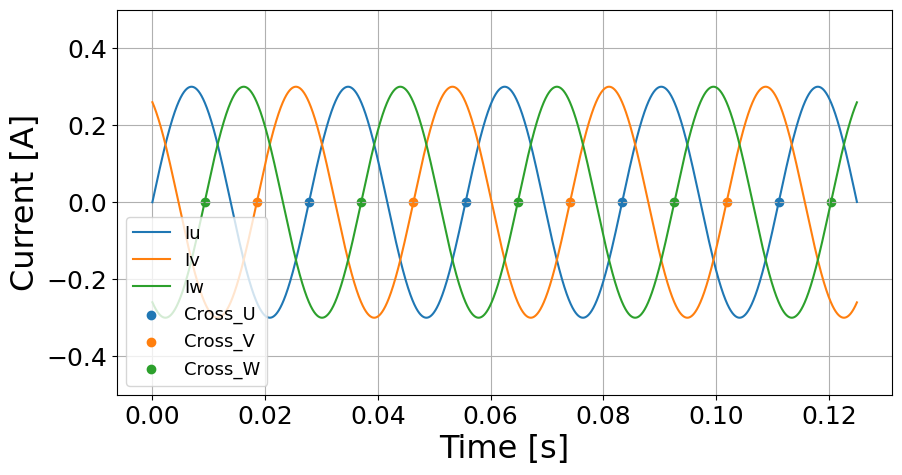

In [25]:
fig = plt.figure(figsize = (10,5))

plt.plot(time, I_u, label='Iu')
plt.plot(time, I_v, label='Iv')
plt.plot(time, I_w, label='Iw')
#plt.plot(time, I_u*V_u, label='Pu')
plt.scatter(time[rise_idx_I_u], I_u[rise_idx_I_u], label='Cross_U')
plt.scatter(time[rise_idx_I_v], I_v[rise_idx_I_v], label='Cross_V')
plt.scatter(time[rise_idx_I_w], I_w[rise_idx_I_w], label='Cross_W')

plt.xlabel('Time [s]',fontsize=23)
plt.ylabel('Current [A]',fontsize=23)
plt.tick_params(labelsize = 18)
plt.ylim(-0.5,0.5)
plt.legend(fontsize=13)
plt.grid()
plt.show()

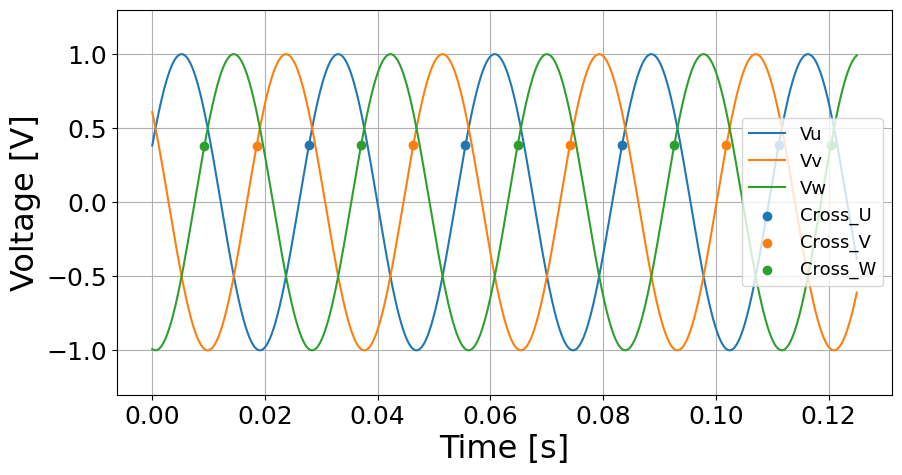

In [26]:
fig = plt.figure(figsize = (10,5))

plt.plot(time, V_u, label='Vu')
plt.plot(time, V_v, label='Vv')
plt.plot(time, V_w, label='Vw')
plt.scatter(time[rise_idx_I_u], V_u[rise_idx_I_u], label='Cross_U')
plt.scatter(time[rise_idx_I_v], V_v[rise_idx_I_v], label='Cross_V')
plt.scatter(time[rise_idx_I_w], V_w[rise_idx_I_w], label='Cross_W')

plt.xlabel('Time [s]',fontsize=23)
plt.ylabel('Voltage [V]',fontsize=23)
plt.tick_params(labelsize = 18)
plt.ylim(-1.3,1.3)
plt.legend(fontsize=13)
plt.grid()
plt.show()

## Slow rotation (~0.11 Hz)

In [27]:
proc_interval = 0.125
sample_rate = 100_000

#mock data (freq is constant)
time = np.arange(0, proc_interval, 1/sample_rate, dtype=np.float32)

Is_u = sine_wave(time, 0.3, 2*np.pi*4, 0)
Is_v = sine_wave(time, 0.3, 2*np.pi*4, 2*np.pi/3)
Is_w = sine_wave(time, 0.3, 2*np.pi*4, 4*np.pi/3)

Vs_u = sine_wave(time, 1.0, 2*np.pi*4, np.pi/8)
Vs_v = sine_wave(time, 1.0, 2*np.pi*4, np.pi/8+2*np.pi/3)
Vs_w = sine_wave(time, 1.0, 2*np.pi*4, np.pi/8+4*np.pi/3)

rise_idx_Is_u = schmitt_trigger(0, -0.1, Is_u)[0]
rise_idx_Is_v = schmitt_trigger(0, -0.1, Is_v)[0]
rise_idx_Is_w = schmitt_trigger(0, -0.1, Is_w)[0]

In [28]:
print(len(rise_idx_Is_u), len(rise_idx_Is_v), len(rise_idx_Is_w))
result_s = calc_power_refact(time, Is_u, Is_v, Is_w, Vs_u, Vs_v, Vs_w, 0, -0.1, sample_rate)
print(result_s)

0 0 1
(0.062494996935129166, 0.017322741, 0.017322741, 0.017322743, 0.051968224)


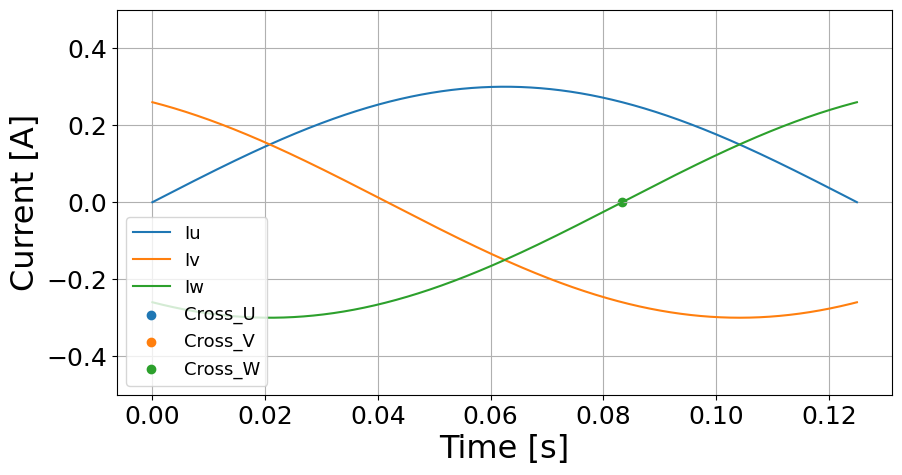

In [29]:
fig = plt.figure(figsize = (10,5))

plt.plot(time, Is_u, label='Iu')
plt.plot(time, Is_v, label='Iv')
plt.plot(time, Is_w, label='Iw')
plt.scatter(time[rise_idx_Is_u], Is_u[rise_idx_Is_u], label='Cross_U')
plt.scatter(time[rise_idx_Is_v], Is_v[rise_idx_Is_v], label='Cross_V')
plt.scatter(time[rise_idx_Is_w], Is_w[rise_idx_Is_w], label='Cross_W')

plt.xlabel('Time [s]',fontsize=23)
plt.ylabel('Current [A]',fontsize=23)
plt.tick_params(labelsize = 18)
plt.ylim(-0.5,0.5)
plt.legend(fontsize=13)
plt.grid()
plt.show()

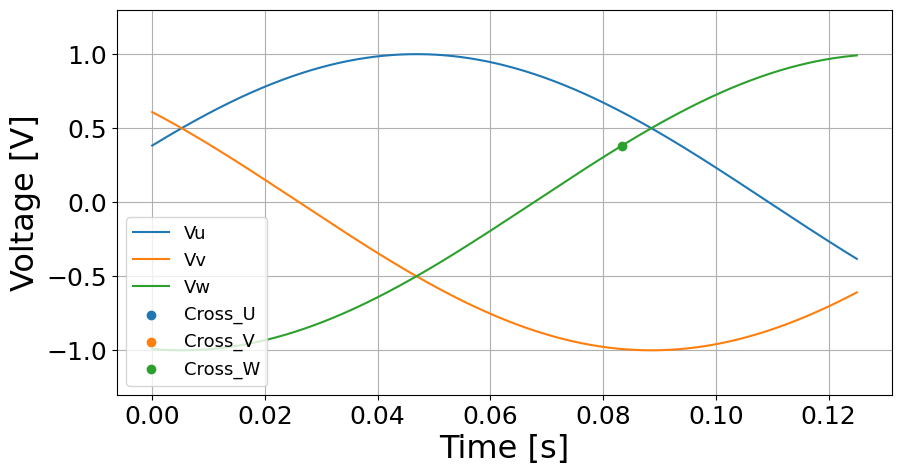

In [30]:
fig = plt.figure(figsize = (10,5))

plt.plot(time, Vs_u, label='Vu')
plt.plot(time, Vs_v, label='Vv')
plt.plot(time, Vs_w, label='Vw')
plt.scatter(time[rise_idx_Is_u], Vs_u[rise_idx_Is_u], label='Cross_U')
plt.scatter(time[rise_idx_Is_v], Vs_v[rise_idx_Is_v], label='Cross_V')
plt.scatter(time[rise_idx_Is_w], Vs_w[rise_idx_Is_w], label='Cross_W')

plt.xlabel('Time [s]',fontsize=23)
plt.ylabel('Voltage [V]',fontsize=23)
plt.tick_params(labelsize = 18)
plt.ylim(-1.3,1.3)
plt.legend(fontsize=13)
plt.grid()
plt.show()

## Chirp Signal

In [31]:
proc_interval = 0.125
sample_rate = 100_000

#mock data (chirp)
time2 = np.arange(0, 10, 1/sample_rate, dtype=np.float32)

def chirp_wave(t,a,b,amp,phase):
    f = a*t + b
    y = amp*np.sin(2.*np.pi*f*t+phase)
    return y,f

Ic_u = chirp_wave(time2, 0.1, 0, 0.3, -np.pi/3)[0]
Ic_v = chirp_wave(time2, 0.1, 0, 0.3, np.pi/3)[0]
Ic_w = chirp_wave(time2, 0.1, 0, 0.3, 3*np.pi/3)[0]

Vc_u = chirp_wave(time2, 0.1, 0, 1.0, np.pi/8-np.pi/3)[0]
Vc_v = chirp_wave(time2, 0.1, 0, 1.0, np.pi/8+np.pi/3)[0]
Vc_w = chirp_wave(time2, 0.1, 0, 1.0, np.pi/8+3*np.pi/3)[0]

rise_idx_Ic_u = schmitt_trigger(0, -0.1, Ic_u)[0]
rise_idx_Ic_v = schmitt_trigger(0, -0.1, Ic_v)[0]
rise_idx_Ic_w = schmitt_trigger(0, -0.1, Ic_w)[0]

In [32]:
print(len(rise_idx_Ic_u), len(rise_idx_Ic_v), len(rise_idx_Ic_w))
result_c = calc_power_refact(time2, Ic_u, Ic_v, Ic_w, Vc_u, Vc_v, Vc_w, 0, -0.1, sample_rate)
print(result_c)

10 10 10
(4.99999475479126, 0.29737338, 0.1952487, 0.22956492, 0.722187)


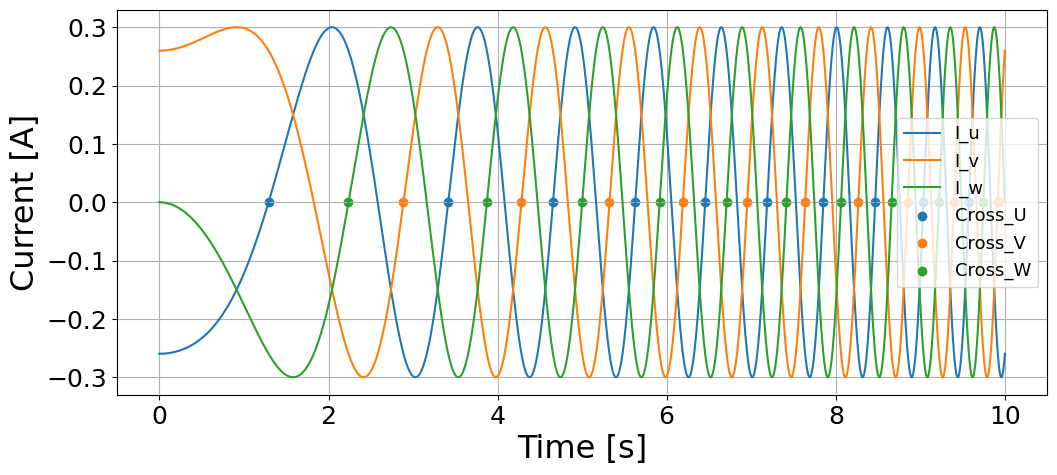

In [33]:
fig = plt.figure(figsize = (12,5))

plt.plot(time2, Ic_u, label='I_u')
plt.plot(time2, Ic_v, label='I_v')
plt.plot(time2, Ic_w, label='I_w')
plt.scatter(time2[rise_idx_Ic_u], Ic_u[rise_idx_Ic_u], label='Cross_U')
plt.scatter(time2[rise_idx_Ic_v], Ic_v[rise_idx_Ic_v], label='Cross_V')
plt.scatter(time2[rise_idx_Ic_w], Ic_w[rise_idx_Ic_w], label='Cross_W')

plt.xlabel('Time [s]',fontsize=23)
plt.ylabel('Current [A]',fontsize=23)
plt.tick_params(labelsize = 18)
#plt.xlim(0,100)
plt.legend(fontsize=13)
plt.grid()
plt.show()

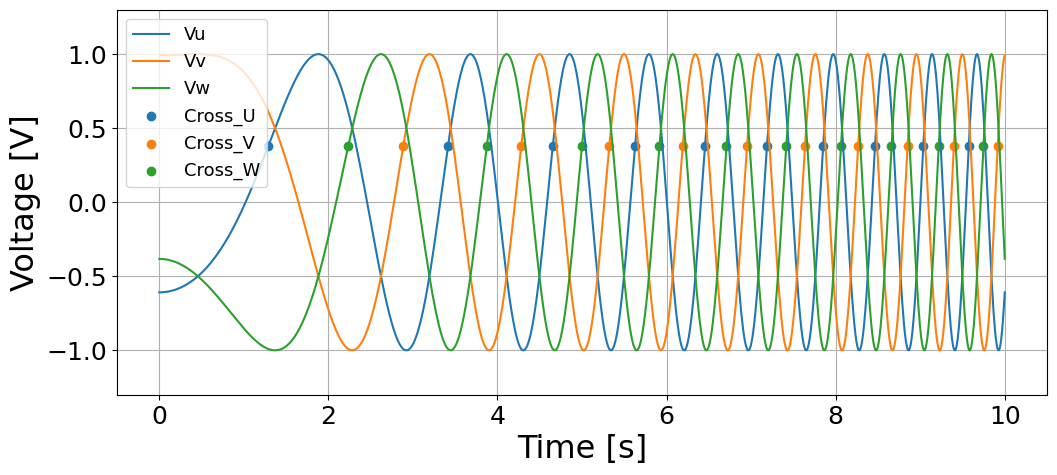

In [34]:
fig = plt.figure(figsize = (12,5))

plt.plot(time2, Vc_u, label='Vu')
plt.plot(time2, Vc_v, label='Vv')
plt.plot(time2, Vc_w, label='Vw')
plt.scatter(time2[rise_idx_Ic_u], Vc_u[rise_idx_Ic_u], label='Cross_U')
plt.scatter(time2[rise_idx_Ic_v], Vc_v[rise_idx_Ic_v], label='Cross_V')
plt.scatter(time2[rise_idx_Ic_w], Vc_w[rise_idx_Ic_w], label='Cross_W')

plt.xlabel('Time [s]',fontsize=23)
plt.ylabel('Voltage [V]',fontsize=23)
plt.tick_params(labelsize = 18)
plt.ylim(-1.3,1.3)
plt.legend(fontsize=13)
plt.grid()
plt.show()

## Chirp signal (with noise)

In [35]:
proc_interval = 0.125
sample_rate = 100_000

#mock data (chirp + noise)
time2 = np.arange(0, 10, 1/sample_rate, dtype=np.float32)
noise = np.random.randn(len(time2))

def chirp_wave(t,a,b,amp,phase):
    f = a*t + b
    y = amp*np.sin(2.*np.pi*f*t+phase)
    return y,f

Icn_u = chirp_wave(time2, 0.1, 0, 0.3, -np.pi/3)[0] + 0.3*0.01*noise
Icn_v = chirp_wave(time2, 0.1, 0, 0.3, np.pi/3)[0] + 0.3*0.01*noise
Icn_w = chirp_wave(time2, 0.1, 0, 0.3, 3*np.pi/3)[0] + 0.3*0.01*noise

Vcn_u = chirp_wave(time2, 0.1, 0, 1.0, np.pi/8-np.pi/3)[0] + 0.01*noise
Vcn_v = chirp_wave(time2, 0.1, 0, 1.0, np.pi/8+np.pi/3)[0] + 0.01*noise
Vcn_w = chirp_wave(time2, 0.1, 0, 1.0, np.pi/8+3*np.pi/3)[0] + 0.01*noise

rise_idx_Icn_u = schmitt_trigger(0, -0.1, Icn_u)[0]
rise_idx_Icn_v = schmitt_trigger(0, -0.1, Icn_v)[0]
rise_idx_Icn_w = schmitt_trigger(0, -0.1, Icn_w)[0]

In [36]:
print(len(rise_idx_Icn_u), len(rise_idx_Icn_v), len(rise_idx_Icn_w))
result_cn = calc_power_refact(time2, Icn_u, Icn_v, Icn_w, Vcn_u, Vcn_v, Vcn_w, 0, -0.1, sample_rate)
print(result_cn)

10 10 11
(4.99999475479126, 0.29743704881895583, 0.1952570891288551, 0.25634430760294263, 0.7490384455507535)


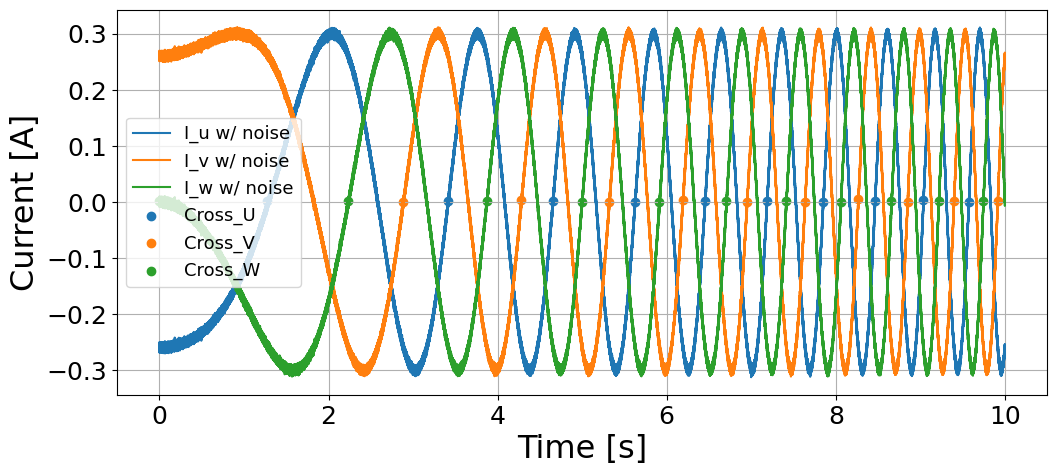

In [37]:
fig = plt.figure(figsize = (12,5))

plt.plot(time2, Icn_u, label='I_u w/ noise')
plt.plot(time2, Icn_v, label='I_v w/ noise')
plt.plot(time2, Icn_w, label='I_w w/ noise')
plt.scatter(time2[rise_idx_Icn_u], Icn_u[rise_idx_Icn_u], label='Cross_U')
plt.scatter(time2[rise_idx_Icn_v], Icn_v[rise_idx_Icn_v], label='Cross_V')
plt.scatter(time2[rise_idx_Icn_w], Icn_w[rise_idx_Icn_w], label='Cross_W')

plt.xlabel('Time [s]',fontsize=23)
plt.ylabel('Current [A]',fontsize=23)
plt.tick_params(labelsize = 18)
#plt.ylim(-0.5,0.5)
plt.legend(fontsize=13)
plt.grid()
plt.show()

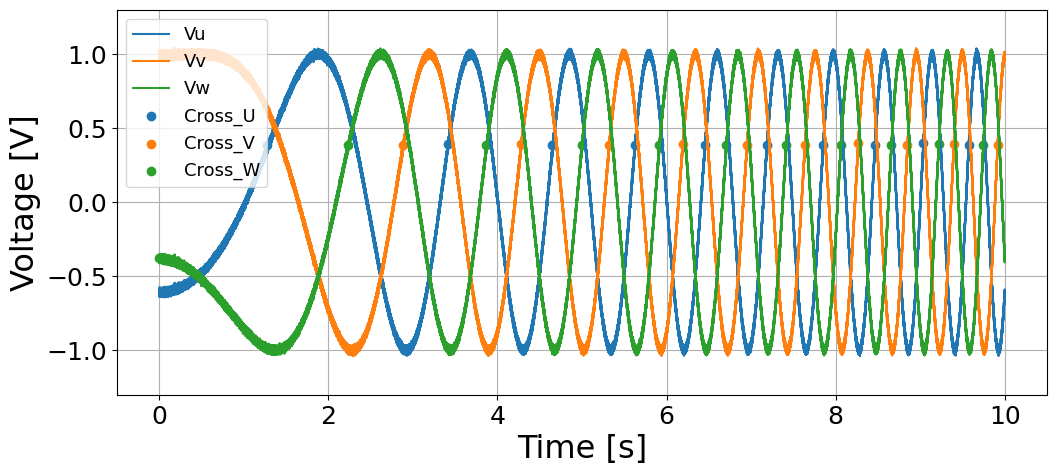

In [38]:
fig = plt.figure(figsize = (12,5))

plt.plot(time2, Vcn_u, label='Vu')
plt.plot(time2, Vcn_v, label='Vv')
plt.plot(time2, Vcn_w, label='Vw')
plt.scatter(time2[rise_idx_Icn_u], Vcn_u[rise_idx_Icn_u], label='Cross_U')
plt.scatter(time2[rise_idx_Icn_v], Vcn_v[rise_idx_Icn_v], label='Cross_V')
plt.scatter(time2[rise_idx_Icn_w], Vcn_w[rise_idx_Icn_w], label='Cross_W')

plt.xlabel('Time [s]',fontsize=23)
plt.ylabel('Voltage [V]',fontsize=23)
plt.tick_params(labelsize = 18)
plt.ylim(-1.3,1.3)
plt.legend(fontsize=13)
plt.grid()
plt.show()